In [2]:
import numpy as np
import scipy as sp
from scipy.sparse import diags
from scipy.sparse import csr_array
from scipy.sparse import linalg
import math
import timeit

import matplotlib.pyplot as plt

# Pre

In [172]:

class SimulationGrid:

    def __init__(self,L,N, k = 3, _type = 'Square', method = 'Fast', eigen = 'True'):
        """

        Creates a simulation grid.

        Inputs:

            - L: Square size, rectangle shape or circle diameter. Without considering boundaries
            - N: Discretization pints for Square side, Rectangle small side and Diameter of circle
            - k: Number of eigen values
        """
        self.L = L
        self.N = N
        self.dx = L/(N-1)
        self.k = k
        self.method = method
        self.eigen = eigen
        self.initialize(_type)
        self.data = [] #For simulations

    def initialize(self,  _type):
        """
        Initializes the v vector and M matrix in function of the type of grid
        """
        if _type == 'Square':
            self.times = timeit.default_timer()
            self.M = self.m_square()/(self.dx**2)
            self.times = timeit.default_timer() - self.times
        elif _type == 'Rectangle':
            self.times = timeit.default_timer()
            self.M = self.m_rectangle()/(self.dx**2)
            self.times = timeit.default_timer() - self.times
        elif _type == 'Circle':
            self.times = timeit.default_timer()
            self.M, self.M_g = self.m_circle()
            self.M = self.M/(self.dx**2)/(self.dx**2)
            self.times = timeit.default_timer() - self.times
        else:
            print("That does not work")
        
        if self.eigen == 'True':
            if _type == 'Circle':
                #self.eigenvalues, self.eigenvectors = sp.linalg.eigh(self.M)
                self.eigenvalues, self.eigenvectors = sp.sparse.linalg.eigs(self.M, k = self.k, sigma = 1)
            else:
                self.eigenvalues, self.eigenvectors = sp.sparse.linalg.eigs(self.M, k = self.k, sigma = 1)
            self.eigenvectors = np.real(self.eigenvectors)
    
    def m_square(self):
        """
        Considers the grid as a square of size L
        """
        n = self.N*self.N 
        
        if self.method == 'Fast':
            x_diag = np.ones(n-1)
            x_diag[np.arange(1,n) % self.N == 0] = 0
            y_diag = np.ones(n - self.N)

            d = [y_diag, x_diag, np.full(n,-4), x_diag, y_diag]
            
            return diags(d , [-self.N,-1,0,1,self.N]).toarray()

        else:
            
            M = np.zeros((n, n))
            for i in range(n):
                M[i, i] = -4
                for j in range(n):
                    if j == i -self.N or j == i + self.N:
                        M[i,j] =  1
                    elif (j == i - 1) and ((j+1) % self.N != 0):
                        M[i,j] = 1
                    elif (j == i +1) and ((j)%self.N != 0):
                        M[i,j] = 1
            return M
        
    def m_rectangle(self):
        """
        Considers the grid as a rectangle of heigh of L and length 2*L
        Inputs:
            - m: Scale from L for Y axis
        """
        n = (self.N)*(self.N)*2
        
        if self.method == 'Fast':
            x_diag = np.ones(n-1)
            x_diag[np.arange(1,n) % self.N == 0] = 0

            y_diag = np.ones(n - self.N)

            d = [y_diag, x_diag, np.full(n,-4), x_diag, y_diag]
            return diags(d , [-self.N,-1,0,1,self.N]).toarray()
        
        else:
            M = np.zeros((n, n))
            for i in range(n):
                M[i, i] = -4
                for j in range(n):
                    if j == i -self.N or j == i + self.N:
                        M[i,j] =  1
                    elif (j == i - 1) and ((j+1) % self.N != 0):
                        M[i,j] = 1
                    elif (j == i +1) and ((j)%self.N != 0):
                        M[i,j] = 1
            
            return M
        
    def m_circle(self):
        """
        Considers the grid as a circle of diameter N. For this discretization, if N is par, then the center is ont, if impair it is 
        """
        n = (self.N)*(self.N)

        M = self.m_square()
        
        center_xy = self.L/2

        distances = np.sqrt(np.sum((np.indices((self.N,self.N))*self.dx - center_xy)**2, axis = 0))
        M_g = np.copy(distances)
        
        positions = np.where(distances.flatten() > self.L/2)[0]
        positions = positions[positions != int(np.floor(n/2))]
        
        
        M_g[M_g > L/2] = 0
        M_g[M_g != 0] = 1
        M_g[int(np.floor(self.N/2)),int(np.floor(self.N/2))] = 1
        
        M = np.delete(M, positions, axis = 0)
        M = np.delete(M, positions, axis = 1)

        return M,M_g
    
    def animation(self,save_animation = False):
        """

        Animates the stepping scheme:

        Inputs:

            -   method: If using time_dependent or time_independent

            -   save_animation: True == it will save the animation, default is False
        """

        fig, ax = plt.subplots()       

        C = np.copy(self.data)


        C = np.copy(self.A)
        

        ax.imshow(C, cmap='hot', interpolation='nearest', extent=[0, 1, 0, 1])

        ax.set_xlabel('X')  

        ax.set_ylabel('Y')  

        ax.set_title('Time: 0 s') 
        
        anim = animation.FuncAnimation(fig,self.frame, fargs= (ax,), frames=int(n_steps), interval = 0.000001)

        if save_animation == True:

            print("Starting ")

            anim.save('time_dependent_diffusion_animation.mp4', fps=60)
            plt.close()

    def frame(self, iteration, ax):

        C = self.data[iteration]

        ax.clear()

        ax.set_title(f'Time dependent(t={np.round(iteration*0.0001*50, 7)}) s')

        ax.imshow(C, cmap='hot', interpolation='nearest', extent=[0, 1, 0, 1])


# Part I

## A

Done

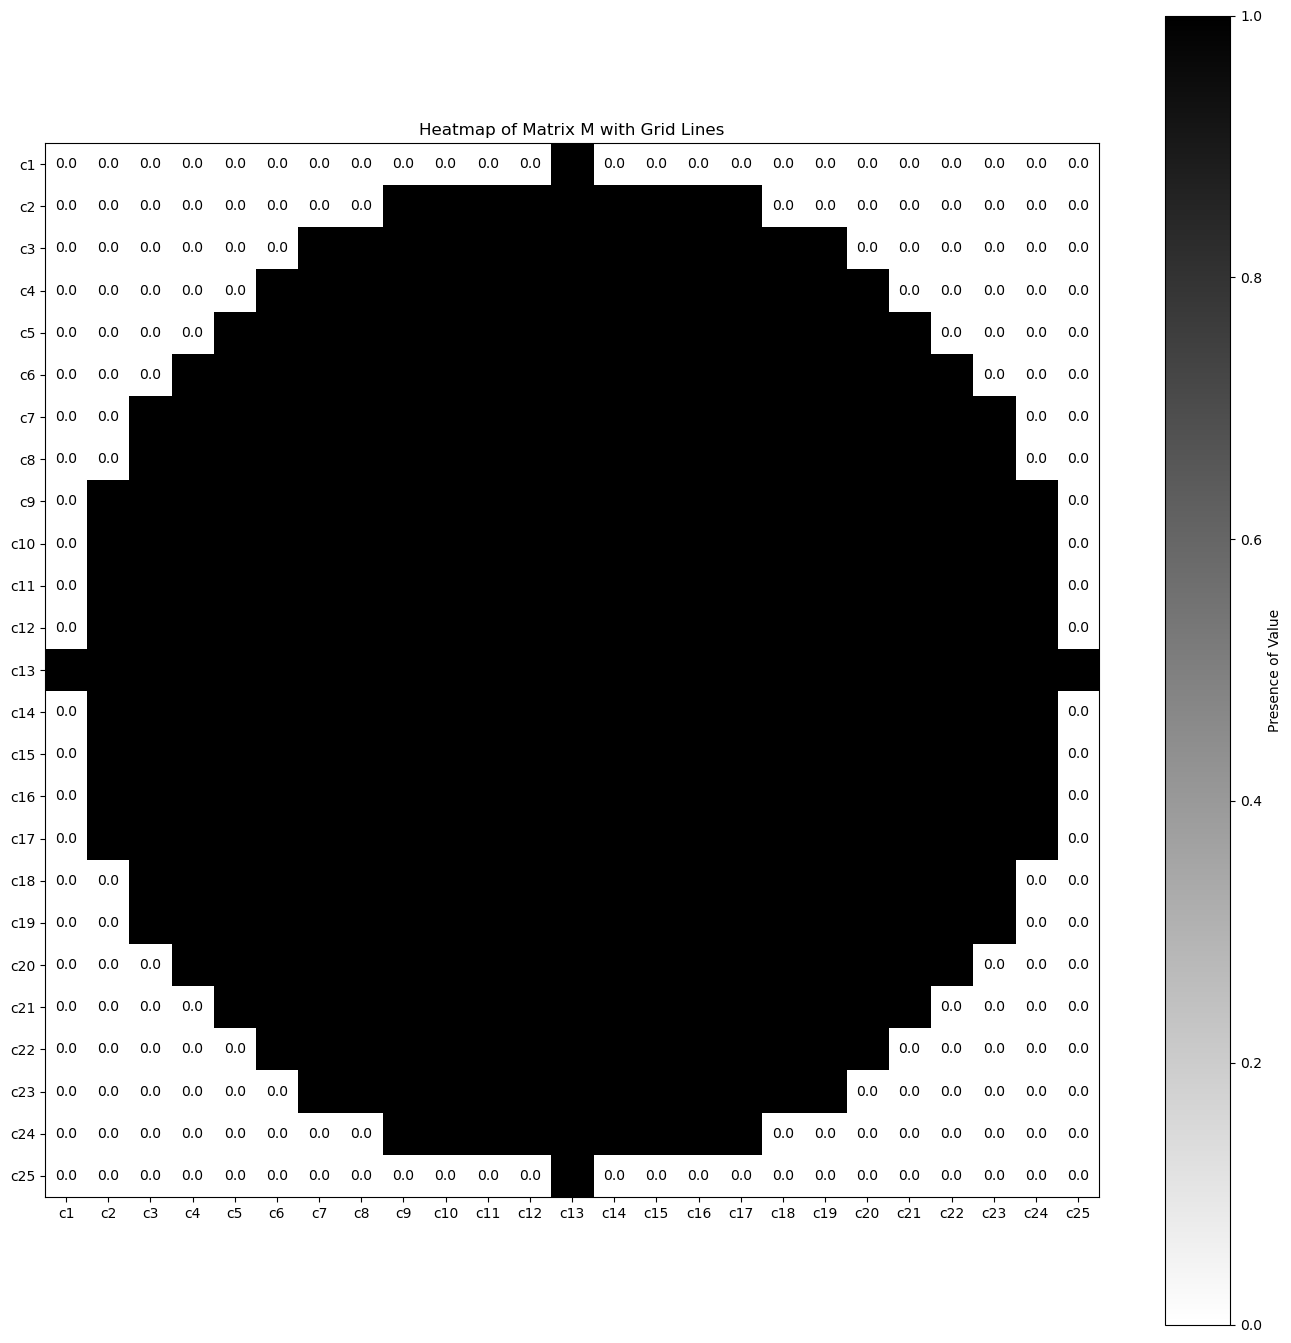

In [164]:
# Create a binary mask where 1 indicates presence of value and 0 indicates absence
mask = circle.M_g != 0
M = circle.M_g
fig, axs = plt.subplots(1,1, figsize = (17,17))
# Plot the heatmap
plt.imshow(mask, cmap='binary', interpolation='nearest')

# Overlay the original matrix values
for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        plt.text(j, i, M[i, j], ha='center', va='center', color='black')

# Add grid lines
#plt.grid(True, which='both', color='black', linestyle='-', linewidth=1)
plt.xticks(np.arange(M.shape[1]), ['c{}'.format(i+1) for i in range(M.shape[1])])
plt.yticks(np.arange(M.shape[0]), ['c{}'.format(i+1) for i in range(M.shape[0])])
# Optionally, you can adjust plot settings
plt.title('Heatmap of Matrix M with Grid Lines')
plt.colorbar(label='Presence of Value')


# Show the plot
plt.show()

## B

In [148]:
def v_conv(v,M):
    
    M_flat = M.flatten()
    v_flat = v.flatten()

    # Assign the values from v to the corresponding positions in M where M is 1
    M_flat[M_flat == 1] = v_flat[:np.sum(M_flat == 1)]

    # Reshape the flattened matrix back to its original shape
    v_r = M_flat.reshape(M.shape)

    return v_r

In [173]:
N = 50
L = 1
k = 3

square = SimulationGrid(L,N,k, _type = 'Square')

rectangle = SimulationGrid(L,N,k, _type = 'Rectangle')

circle = SimulationGrid(L,N,k, _type = 'Circle')

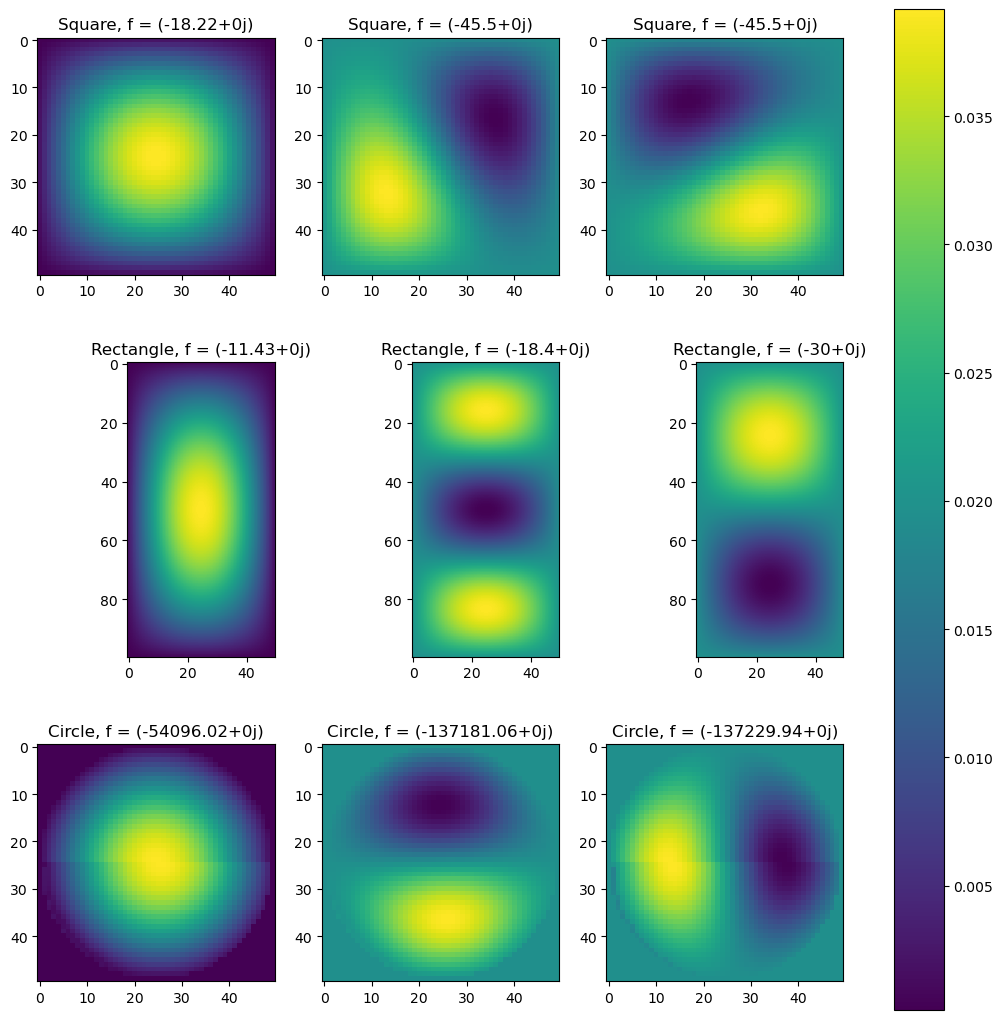

In [174]:
fig,axs = plt.subplots(3,3, figsize = (13,13))
axs = axs.flatten()
r = 1

msq = 0
mrc = 0
mci = 0

axs[0].imshow(square.eigenvectors[:,msq].reshape(N,N))
axs[0].set_title(f'Square, f = {np.round(square.eigenvalues[m],2)}')

axs[1].imshow(square.eigenvectors[:,msq - r].reshape(N,N))
axs[1].set_title(f'Square, f = {np.round(square.eigenvalues[m + r],2)}')

axs[2].imshow(square.eigenvectors[:,msq - 2*r].reshape(N,N))
axs[2].set_title(f'Square, f = {np.round(square.eigenvalues[m + 2*r],2)}')


axs[3].imshow(rectangle.eigenvectors[:,mrc].reshape(2*N,N))
axs[3].set_title(f'Rectangle, f = {np.round(rectangle.eigenvalues[m],2)}')

axs[4].imshow(rectangle.eigenvectors[:,mrc - r].reshape(2*N,N))
axs[4].set_title(f'Rectangle, f = {np.round(rectangle.eigenvalues[m + r],2)}')

axs[5].imshow(rectangle.eigenvectors[:,mrc - 2*r].reshape(2*N,N))
axs[5].set_title(f'Rectangle, f = {np.round(rectangle.eigenvalues[m + 2*r],2)}')



axs[6].imshow(v_conv(circle.eigenvectors[:,mci],circle.M_g))
axs[6].set_title(f'Circle, f = {np.round(circle.eigenvalues[m],2)}')

axs[7].imshow(v_conv(circle.eigenvectors[:,mci - r],circle.M_g))
axs[7].set_title(f'Circle, f = {np.round(circle.eigenvalues[m + r],2)}')

axs[8].imshow(v_conv(circle.eigenvectors[:,mci - 2*r],circle.M_g))
axs[8].set_title(f'Circle, f = {np.round(circle.eigenvalues[m + 2*r],2)}')

fig.colorbar(axs[0].imshow(square.eigenvectors[:, msq].reshape(N, N)), ax=axs, orientation='vertical')


## C

In [279]:
L = 1
num = 20

Ns = np.linspace(10,50,num = num, dtype = int)
time_f = np.zeros((3,num))
time_l = np.zeros((3,num))

for i,N in enumerate(Ns):
    square = SimulationGrid(L,N, _type = 'Square',method = 'Slow', eigen= 'False')
    time_l[0,i] = square.times

    square = SimulationGrid(L,N, _type = 'Square', eigen= 'False')
    time_f[0,i] = square.times

    rectangle = SimulationGrid(L,N, _type = 'Rectangle',method = 'Slow', eigen= 'False')
    time_l[1,i] = rectangle.times

    rectangle = SimulationGrid(L,N, _type = 'Rectangle', eigen= 'False')
    time_f[1,i] = rectangle.times

    circle = SimulationGrid(L,N, _type = 'Circle',method = 'Slow', eigen= 'False')
    time_l[2,i] = circle.times

    circle = SimulationGrid(L,N, _type = 'Circle', eigen= 'False')
    time_f[2,i] = circle.times

10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
30


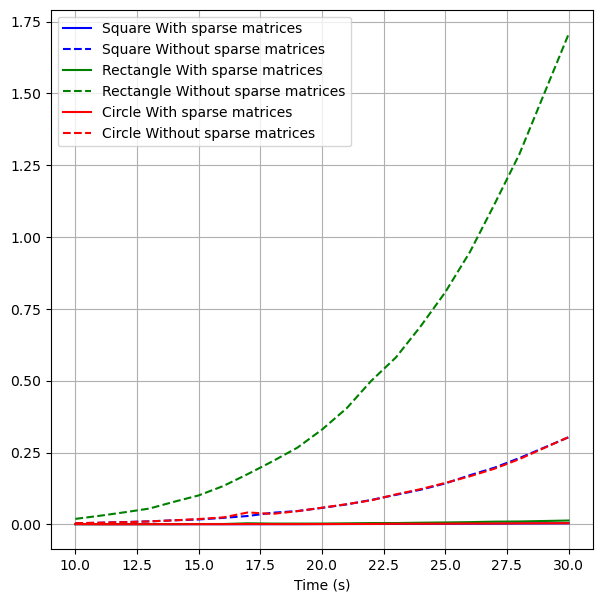

In [289]:
fig,axs = plt.subplots(1,1, figsize = (7,7))

names = ['Square', 'Rectangle', 'Circle']
colors = ['b','g','r']
for i in range(3):
    axs.plot(Ns,time_f[i],color = colors[i] , label = f'{names[i]} With sparse matrices')
    axs.plot(Ns,time_l[i], color = colors[i], linestyle = '--',label = f'{names[i]} Without sparse matrices')

axs.set_xlabel('Discretization points (N)')
axs.set_xlabel('Time (s)')
axs.grid(True)
axs.legend()

## D

In [3]:
T = 25
Ls = np.linspace(1,50, num = T)
Ns = np.linspace(10,110, num = T, dtype = int)

N = 50
L = 10
k = 1

L_change_sq = np.zeros((3,T))
L_change_rc = np.zeros((3,T))
L_change_ci = np.zeros((3,T))

N_change_rc = np.zeros((3,T))
N_change_sq = np.zeros((3,T))
N_change_ci = np.zeros((3,T))

for j,Li in enumerate(Ls):
    square = SimulationGrid(Li,N,k, _type = 'Square')
    rectangle = SimulationGrid(Li,N,k, _type = 'Rectangle')
    circle = SimulationGrid(Li,N,k, _type = 'Circle')
    for i in range(3):
        L_change_sq[i,j] = square.eigenvalues[i]
        L_change_rc[i,j] = rectangle.eigenvalues[i]
        L_change_ci[i,j] = circle.eigenvalues[i]
    

for j,Ni in enumerate(Ns):
    square = SimulationGrid(L,Ni,k, _type = 'Square')
    rectangle = SimulationGrid(L,Ni,k, _type = 'Rectangle')
    circle = SimulationGrid(L,Ni,k, _type = 'Circle')
    for i in range(3):
        N_change_sq[i,j] = square.eigenvalues[i]
        N_change_rc[i,j] = rectangle.eigenvalues[i]
        N_change_ci[i,j] = circle.eigenvalues[i]


C:\Users\joann\AppData\Local\Temp\ipykernel_32064\3899139329.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  L_change_sq[i,j] = square.eigenvalues[i]
C:\Users\joann\AppData\Local\Temp\ipykernel_32064\3899139329.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  L_change_rc[i,j] = rectangle.eigenvalues[i]
C:\Users\joann\AppData\Local\Temp\ipykernel_32064\3899139329.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  L_change_ci[i,j] = circle.eigenvalues[i]


L1.0
L3.0416666666666665
L5.083333333333333
L7.125
L9.166666666666666
L11.208333333333332
L13.25
L15.291666666666666
L17.333333333333332
L19.375
L21.416666666666664
L23.458333333333332
L25.5
L27.541666666666664
L29.583333333333332
L31.624999999999996
L33.666666666666664
L35.70833333333333
L37.75
L39.791666666666664
L41.83333333333333
L43.875
L45.916666666666664
L47.95833333333333
L50.0
N10
N14
N18
N22


C:\Users\joann\AppData\Local\Temp\ipykernel_32064\3899139329.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
  N_change_sq[i,j] = square.eigenvalues[i]
C:\Users\joann\AppData\Local\Temp\ipykernel_32064\3899139329.py:33: ComplexWarning: Casting complex values to real discards the imaginary part
  N_change_rc[i,j] = rectangle.eigenvalues[i]
C:\Users\joann\AppData\Local\Temp\ipykernel_32064\3899139329.py:34: ComplexWarning: Casting complex values to real discards the imaginary part
  N_change_ci[i,j] = circle.eigenvalues[i]


N26
N30
N35
N39
N43
N47
N51
N55
N60
N64
N68
N72
N76
N80
N85
N89
N93
N97
N101
N105
N110


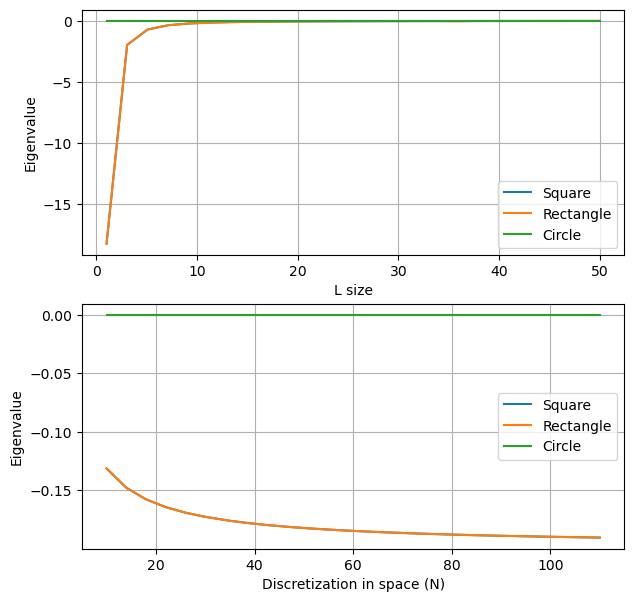

In [5]:
fig,axs = plt.subplots(2,1, figsize = (7,7))

axs = axs.flatten()

axs[0].plot(Ls,L_change_sq[0], label = 'Square')
axs[0].plot(Ls,L_change_rc[0], label = 'Rectangle')
axs[0].plot(Ls,L_change_ci[0], label = 'Circle')
axs[0].set_xlabel('L size')
axs[0].set_ylabel('Eigenvalue')

axs[0].legend()
axs[0].grid(True)

axs[1].plot(Ns,N_change_sq[0], label = 'Square')
axs[1].plot(Ns,N_change_rc[0], label = 'Rectangle')
axs[1].plot(Ns,N_change_ci[0], label = 'Circle')
axs[1].set_xlabel('Discretization in space (N)')
axs[1].set_ylabel('Eigenvalue')
axs[1].grid(True)
axs[1].legend()

## Part II

In [ ]:
L = 2
circle = SimulationGrid(L, _type = 'Circle')
c = np.array([])